# The Daubechies D4 Wavelet Tranform

In [17]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from time import time


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [18]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [19]:
def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width, details = None):
    if (scale == 1) :
    
        daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
        result_H = np.dot(daubechies_coeffs_transpose, transform_result)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)
        
        return np.array(image)
    
    else: 
        aP,_,_,_ = split_matrix(transform_result)
        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0])

## NUMERICS EXAMPLE

In [20]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.      0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.      0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.      0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.      0.2241 -0.1294  0.      0.      0.8365]
 [ 0.8365  0.      0.     -0.1294 -0.2241  0.      0.     -0.483 ]
 [ 0.2241  0.483   0.      0.      0.8365 -0.1294  0.      0.    ]
 [-0.1294  0.8365  0.      0.     -0.483  -0.2241  0.      0.    ]
 [ 0.      0.2241  0.483   0.      0.      0.8365 -0.1294  0.    ]
 [ 0.     -0.1294  0.8365  0.      0.     -0.483  -0.2241  0.    ]
 [ 0.      0.   

In [21]:
print(f"Original Matrix:\n {example}\n")
aP,cH,cV,cD = split_matrix(example)

dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,1,example.shape[0])
# idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,2,dwt.shape[0])
print(f"\n {np.round(dwt,0)}")
print(f"\n {np.round(new_p(dwt),0)}")
# print(f"\n {np.round(idwt,0)}")

Original Matrix:
 [[38  8 17 31 31 33 32 36]
 [21 13  1 17 36 29 20  0]
 [ 1 30 28 26 32 42 30 18]
 [ 1 34 19  4 29  0 34 28]
 [26 13 50 45  3  3 28 25]
 [ 7  6  7 26 44 11  2 43]
 [44 21  8  8 12  9 39 27]
 [ 8 51 20 48 34 38  6 28]]


 [[ 30.  40.  70.  37. -14.   7.   3.  13.]
 [ 47.  43.  40.  46.  11.   9.  17. -30.]
 [ 23.  54.  23.  58.  -0.  14. -11.   4.]
 [ 60.  56.  52.  52. -19.  -3. -11. -11.]
 [  1.  13.  21.  -5.   4. -15.  -4.  -9.]
 [ 10.  27. -18.   3.  14. -29.  19.  17.]
 [  6. -31. -13.  17.   3.   0.  29.  26.]
 [ -4.   8.   3.  27.   5.  -5.  -2.  13.]]

 [[153. 177. 255. 172.  41.  96.  85. 112.]
 [195. 187. 178. 194. 106. 101. 119.   2.]
 [134. 214. 135. 225.  77. 114.  49.  88.]
 [228. 218. 208. 208.  29.  71.  49.  50.]
 [ 79. 110. 131.  64.  88.  39.  68.  54.]
 [103. 145.  33.  84. 113.   4. 125. 121.]
 [ 93.   0.  44. 120.  85.  79. 150. 143.]
 [ 69.  99.  85. 146.  91.  66.  73. 109.]]


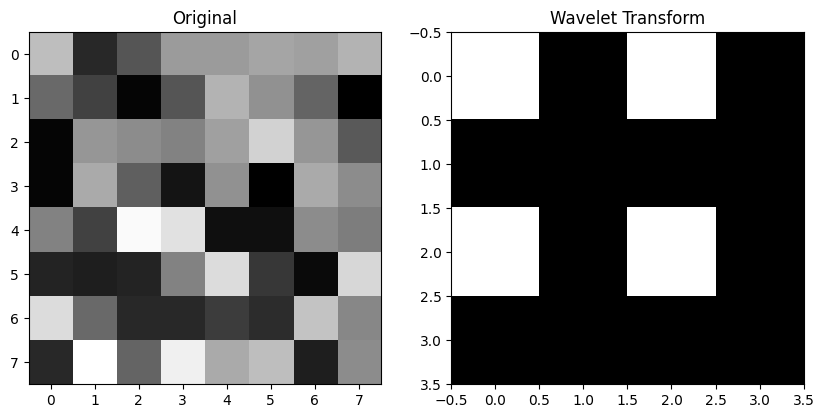

In [22]:
# imshow(np.concatenate((example,idwt), axis = 1))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(example, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((idwt), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

## IMAGES EXAMPLES

In [23]:
photo = 'imagen.jpg'

In [24]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 2, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)

# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(array_photo, cmap='gray')
# ax[0].set_title('Original')
# ax[1].imshow((normalized), cmap='gray')
# ax[1].set_title('Wavelet Transform')
# plt.show()
final_time = time()
execution_time = final_time - initial_time
print(execution_time)
imshow(np.concatenate((result_img,normalized), axis = 1))